# Accessing GBIF Parquet data from AWS using duckdb

In [1]:
import duckdb

In [2]:
con = duckdb.connect()
con.execute("INSTALL httpfs")
con.execute("LOAD httpfs")

In [12]:
query = f'''
SELECT "class", longitude, latitude, COALESCE(n, 0.0) AS n
FROM (
  SELECT "class", longitude, latitude, COUNT(*) AS n
  FROM (
    SELECT DISTINCT
      "class",
      genus,
      ROUND(decimallongitude, CAST(ROUND(0.0, 0) AS INTEGER)) AS longitude,
      ROUND(decimallatitude, CAST(ROUND(0.0, 0) AS INTEGER)) AS latitude
    FROM read_parquet("s3://gbif-open-data-us-east-1/occurrence/2023-02-01/occurrence.parquet/*")
    WHERE (phylum = 'Chordata')
  )
  GROUP BY "class", longitude, latitude
)
'''

res = con.execute(query)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [13]:
df = res.df()
df

,class,longitude,latitude,n
0,Aves,8.0,61.0,245.0
1,Aves,19.0,69.0,248.0
2,NaN,9.0,59.0,83.0
3,Aves,8.0,58.0,254.0
4,Aves,6.0,60.0,158.0
...,...,...,...,...
170609,NaN,-82.0,-12.0,1.0
170610,Mammalia,-94.0,63.0,2.0
170611,Testudines,56.0,12.0,1.0
170612,Aves,-159.0,-29.0,1.0


In [64]:
import numpy as np
mammals = df[df["class"] == "Mammalia"]
mammals = mammals.assign(logn = np.log(mammals.n.values))
mammals


,class,longitude,latitude,n,geometry,logn
7,Mammalia,9.0,58.0,36.0,POINT (9.00000 58.00000),3.583519
54,Mammalia,15.0,78.0,19.0,POINT (15.00000 78.00000),2.944439
61,Mammalia,10.0,62.0,35.0,POINT (10.00000 62.00000),3.555348
64,Mammalia,10.0,63.0,52.0,POINT (10.00000 63.00000),3.951244
212,Mammalia,5.0,47.0,64.0,POINT (5.00000 47.00000),4.158883
...,...,...,...,...,...,...
170595,Mammalia,-136.0,-69.0,1.0,POINT (-136.00000 -69.00000),0.000000
170596,Mammalia,16.0,7.0,1.0,POINT (16.00000 7.00000),0.000000
170598,Mammalia,-104.0,79.0,1.0,POINT (-104.00000 79.00000),0.000000
170610,Mammalia,-94.0,63.0,2.0,POINT (-94.00000 63.00000),0.693147


In [65]:
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

def cube(df):
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='epsg:4326')
    geo_grid = make_geocube(
        vector_data=gdf,
        measurements=['logn'],
        resolution=1,
        rasterize_function=rasterize_points_griddata,
    )
    return geo_grid

geo_grid = cube(mammals)


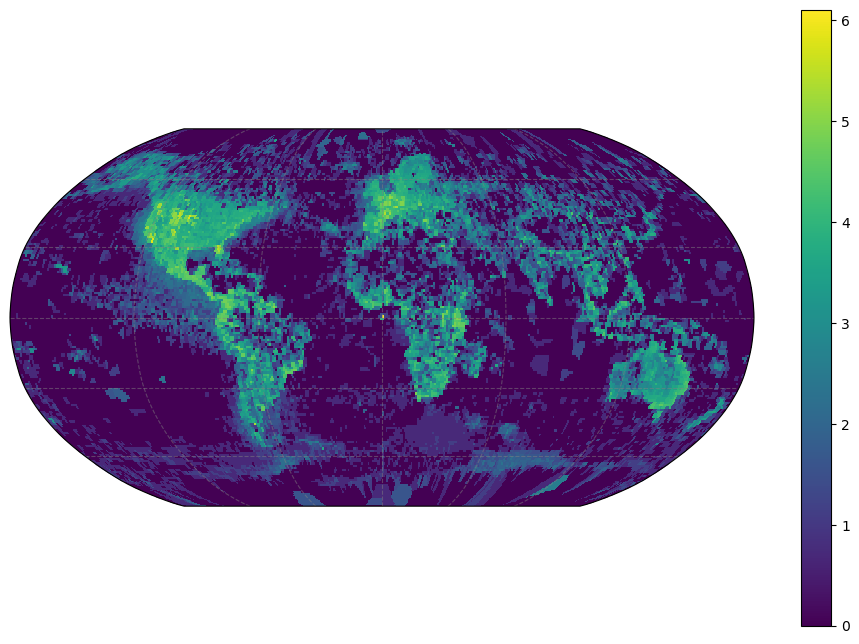

In [67]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = geo_grid.logn.plot(cmap='viridis',
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False)

p.axes.gridlines(color='grey', alpha=0.5, linestyle='--')

# zoom in
# p.axes.set_extent([-19, 33, 30, 66], crs=ccrs.PlateCarree())
